In [1]:
import os
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import pandas as pd
%matplotlib inline

from time import time

from sklearn import metrics
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, Normalizer
from sklearn.model_selection import RandomizedSearchCV

from trackml.dataset import load_event, load_dataset
from trackml.score import score_event



from scipy import spatial

In [2]:
path_to_train = "/home/cameron/Documents/Computational_Physics/train_1"

In [3]:
event_prefix = "event000001000"

In [4]:
hits, cells, particles, truth = load_event(os.path.join(path_to_train, event_prefix))

In [56]:
hits.head()

,hit_id,x,y,z,volume_id,layer_id,module_id,x2,y2,z2
0,1,-64.409897,-7.163700,-1502.5,7,2,1,-0.042829,-0.004763,-23.184208
1,2,-55.336102,0.635342,-1502.5,7,2,1,-0.036804,0.000423,-27.150467
2,3,-83.830498,-1.143010,-1502.5,7,2,1,-0.055707,-0.000760,-17.921406
3,4,-96.109100,-8.241030,-1502.5,7,2,1,-0.063835,-0.005474,-15.576118
4,5,-62.673599,-9.371200,-1502.5,7,2,1,-0.041676,-0.006232,-23.709833


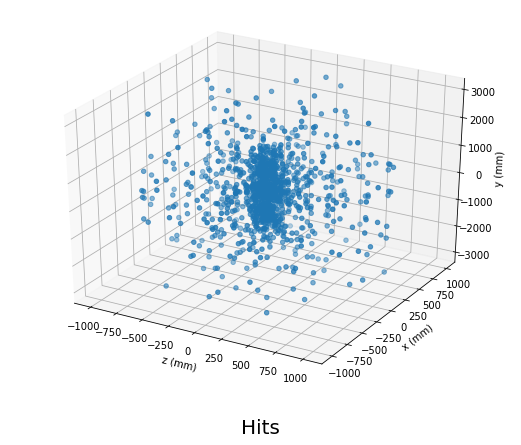

In [61]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(122,projection='3d')

x = hits['x']
x1 = x[::100]
y = hits['y']
y1 = y[::100]
z = hits['z']
z1 = z[::100]

ax.scatter(x1,y1,z1)

ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.set_title("Hits", y=-.15, size=20)

plt.show()

In [58]:
cells.head()

,hit_id,ch0,ch1,value
0,1,209,617,0.013832
1,1,210,617,0.079887
2,1,209,618,0.211723
3,2,68,446,0.334087
4,3,58,954,0.034005


In [59]:
particles.head()

,particle_id,vx,vy,vz,px,py,pz,q,nhits
0,4503668346847232,-0.009288,0.009861,-0.077879,-0.055269,0.323272,-0.203492,-1,8
1,4503737066323968,-0.009288,0.009861,-0.077879,-0.948125,0.470892,2.010060,1,11
2,4503805785800704,-0.009288,0.009861,-0.077879,-0.886484,0.105749,0.683881,-1,0
3,4503874505277440,-0.009288,0.009861,-0.077879,0.257539,-0.676718,0.991616,1,12
4,4503943224754176,-0.009288,0.009861,-0.077879,16.439400,-15.548900,-39.824902,1,3


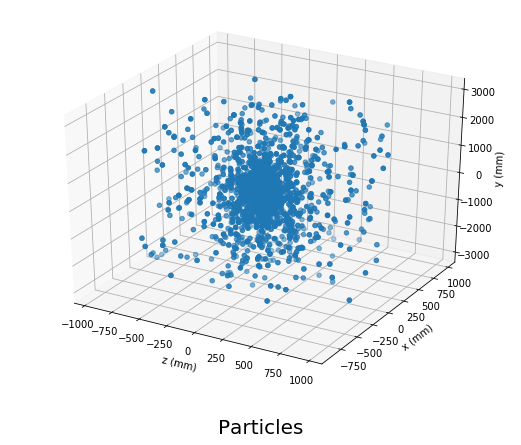

In [62]:
fig = plt.figure(figsize=(20,7))
ax = fig.add_subplot(122,projection='3d')

x = particles['vx']
x1 = x[::10]
y = particles['vy']
y1 = y[::10]
z = particles['vz']
z1 = z[::10]

ax.scatter(x,y,z)

ax.set_xlabel('z (mm)')
ax.set_ylabel('x (mm)')
ax.set_zlabel('y (mm)')
ax.set_title("Particles", y=-.15, size=20)

plt.show()

In [8]:
truth.head()

,hit_id,particle_id,tx,ty,tz,tpx,tpy,tpz,weight
0,1,0,-64.411598,-7.164120,-1502.5,250710.000000,-149908.000000,-956385.00000,0.000000
1,2,22525763437723648,-55.338501,0.630805,-1502.5,-0.570605,0.028390,-15.49220,0.000010
2,3,0,-83.828003,-1.145580,-1502.5,626295.000000,-169767.000000,-760877.00000,0.000000
3,4,297237712845406208,-96.122902,-8.230360,-1502.5,-0.225235,-0.050968,-3.70232,0.000008
4,5,418835796137607168,-62.659401,-9.375040,-1502.5,-0.281806,-0.023487,-6.57318,0.000009


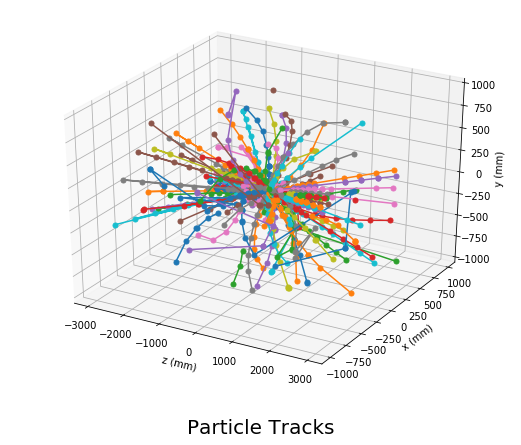

In [24]:
#Plot from Joshua Bonatt
tracks = truth.particle_id.unique()[1::100]
fig = plt.figure(figsize=(20,7))

ax2 = fig.add_subplot(122,projection='3d')
for track in tracks:
    hit_ids = truth[truth['particle_id'] == track]['hit_id']
    t = hits[hits['hit_id'].isin(hit_ids)][['x', 'y', 'z']]
    ax2.plot3D(t.z, t.x, t.y, '.-', ms=10)
    
ax2.set_xlabel('z (mm)')
ax2.set_ylabel('x (mm)')
ax2.set_zlabel('y (mm)')
ax2.set_title("Particle Tracks", y=-.15, size=20)

plt.show()

In [12]:
#Based of of code from Mikhail Hushchyn
class Clusterer(object):
    
    def __init__(self, eps):
        self.eps = eps
        
    
    def _preprocess(self, hits):
        
        x = hits.x.values
        y = hits.y.values
        z = hits.z.values

        r = np.sqrt(x**2 + y**2 + z**2)
        hits['x2'] = x/r
        hits['y2'] = y/r

        r = np.sqrt(x**2 + y**2)
        hits['z2'] = z/r

        ss = StandardScaler()
        X = ss.fit_transform(hits[['x2', 'y2', 'z2']].values)
        
        return X
    
    
    def predict(self, hits):
        
        X = self._preprocess(hits)
        
        clf = DBSCAN(eps=self.eps, min_samples=1, algorithm='auto', n_jobs=-1)
        labels = clf.fit_predict(X)
        
        return labels

In [13]:
model = Clusterer(eps=0.00738)
labels = model.predict(hits)

In [14]:
def create_one_event_submission(event_id, hits, labels):
    sub_data = np.column_stack(([event_id]*len(hits), hits.hit_id.values, labels))
    submission = pd.DataFrame(data=sub_data, columns=["event_id", "hit_id", "track_id"]).astype(int)
    return submission

In [15]:
submission = create_one_event_submission(0, hits, labels)

In [16]:
#Alternative scoring function from CPMP
def score_event_fast(truth, submission):
    truth = truth[['hit_id', 'particle_id', 'weight']].merge(submission, how='left', on='hit_id')
    df = truth.groupby(['track_id', 'particle_id']).hit_id.count().to_frame('count_both').reset_index()
    truth = truth.merge(df, how='left', on=['track_id', 'particle_id'])
    
    df1 = df.groupby(['particle_id']).count_both.sum().to_frame('count_particle').reset_index()
    truth = truth.merge(df1, how='left', on='particle_id')
    df1 = df.groupby(['track_id']).count_both.sum().to_frame('count_track').reset_index()
    truth = truth.merge(df1, how='left', on='track_id')
    truth.count_both *= 2
    score = truth[(truth.count_both > truth.count_particle) & (truth.count_both > truth.count_track)].weight.sum()
    return score

In [17]:
score = score_event_fast(truth, submission)
print("Your score: ", score)

Your score:  0.20306711
